# Notebook for Adding Elevation Data from USGS DEM to OSM
---
Method based on [Liu et al. 2018](https://doi.org/10.1016/j.trc.2018.05.004)

In [ ]:
import geopandas as gpd
import contextily as cx
import pandas as pd
import rasterio
from rasterio.features import geometry_mask
from rasterio.plot import show
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import box, mapping
from shapely.ops import Point
from tqdm import tqdm
import pyproj
import math
import json
from shapely.ops import LineString
import pickle

import src.elevation_tools as elevation_tools

In [ ]:
import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

# Import Network 

In [ ]:
links = gpd.read_file(config['osmdwnld_fp'] / f"osm_{config['geofabrik_year']}.gpkg",layer="raw")
links.set_index('osmid',inplace=True)
links.to_crs('epsg:4326',inplace=True)

# Get DEM TIFF download links from [USGS.gov](https://apps.nationalmap.gov/downloader/#/?z=4&y=37.99999999999999&x=-95&basemap=usgs_topo&datasets=&layerIds=)

In [ ]:
#TODO add compression to reduce the file size or make it so that it reads the data live instead of downloading it
dem_urls = elevation_tools.get_dem_urls(links)
print(len(dem_urls),'TIFF files for the provided network')
print("Names:",set([dem_url.split('/')[-3] for dem_url in dem_urls]))
#if you want to download the DEM files run this
#elevation_tools.download_dem(urls,config['usgs_fp'])

# Project Network to Same CRS as TIFF

In [ ]:
dem_crs = rasterio.open(dem_urls[0]).crs
links.to_crs(dem_crs,inplace=True)

# Sampling Settings (Default is 10m)
If a link is shorter than this, only the start and end point will be used. Last point will always be included in the profile (e.g., link with length 11 m will be sampled at 0, 10, and 11 meters)

In [ ]:
interpolate_dist_m = 10
print((links.length < interpolate_dist_m).sum(),'links of',links.shape[0] ,'total were less than',interpolate_dist_m,'meters')
print(links[links.length<interpolate_dist_m].length.sum().round(0),'of',links.length.sum().round(0),'meters')

# Interpolate points on each line

In [ ]:
interpolated_points_dict = elevation_tools.interpolate_points(links,interpolate_dist_m)

# Sample values from DEM (17-25 minutes for study area)
Replace the nan values on the interpolated points.

In [ ]:
for dem_url in tqdm(dem_urls):
    elevation_tools.sample_elevation(dem_url,links,interpolated_points_dict)

# Export

In [ ]:
#for storing the interpolated points with sampled elevation data
import pickle
with (config['network_fp']/'elevation.pkl').open('wb') as fh:
    pickle.dump(interpolated_points_dict,fh)

# Get Bridge Deck Elevations from USGS LiDAR
Install [laspy and lazrs](https://laspy.readthedocs.io/en/latest/installation.html). This step takes a while (~2 hours)

In [ ]:
links.to_crs('epsg:4326',inplace=True)

In [ ]:
from importlib import reload
lidar_urls = elevation_tools.get_lidar_urls(links)
print(len(lidar_urls),'LAZ files for the provided network')
print("Names:",set([lidar_url.split('/')[-3] for lidar_url in lidar_urls]))

In [ ]:
golden_gate_bridge_example = ["https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/LPC/Projects/CA_West_Coast_LiDAR_2016_B16/CA_WestCoastElNinoUTM10_2016/LAZ/USGS_LPC_CA_West_Coast_LiDAR_2016_B16_10SEG54454185.laz"]

In [ ]:
bridge_decks = elevation_tools.get_bridge_decks(lidar_urls)

In [ ]:
with (config['network_fp']/'bridge_deck_elevations.pkl').open('wb') as fh:
    pickle.dump(bridge_decks,fh)

# Sample Bridges from LiDAR

In [ ]:
links = gpd.read_file(config['osmdwnld_fp'] / f"osm_{config['geofabrik_year']}.gpkg",layer="raw")
links.set_index('osmid',inplace=True)
links.to_crs('epsg:4326',inplace=True)

In [ ]:
with (config['network_fp']/'elevation.pkl').open('rb') as fh:
    interpolated_points_dict = pickle.load(fh)

In [ ]:
with (config['network_fp']/'bridge_deck_elevations.pkl').open('rb') as fh:
    bridge_decks = pickle.load(fh)
bridge_decks.to_crs(dem_crs)

In [37]:
with Path(r"D:\RAW\USGS\lidar_points.pkl").open('rb') as fh:
    bridge_decks = pickle.load(fh)


In [38]:
bridge_decks.to_crs(dem_crs,dem_crs,inplace=True)

<module 'src.elevation_tools' from 'c:\\Users\\tpassmore6\\Documents\\GitHub\\BikewaySimDev\\network\\src\\elevation_tools.py'>

In [44]:
#bridge_linkids = links[links['bridge'].notna()].index.tolist()
bridge_linkids = [26800206]
elevation_tools.sample_lidar(bridge_linkids,interpolated_points_dict,bridge_decks,dem_crs)

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


In [46]:
interpolated_points_dict[26800206]

{'geometry': array([[ 741651.62332318, 3740477.30963046],
        [ 741641.62353736, 3740477.2451898 ],
        [ 741631.62365241, 3740477.19722037],
        [ 741621.62376746, 3740477.14925095],
        [ 741611.62388252, 3740477.10128152],
        [ 741601.62399757, 3740477.0533121 ],
        [ 741591.62411263, 3740477.00534267],
        [ 741581.62422768, 3740476.95737325],
        [ 741571.62434273, 3740476.90940382],
        [ 741561.62445779, 3740476.8614344 ],
        [ 741551.62457284, 3740476.81346497],
        [ 741541.62468789, 3740476.76549555],
        [ 741531.62480295, 3740476.71752612],
        [ 741521.62487046, 3740476.68082639],
        [ 741511.62493669, 3740476.6444322 ],
        [ 741501.62500292, 3740476.608038  ]]),
 'distances': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150]),
 'elevations': array([292. , 290. , 287.4, 284.8, 284.5, 284.4, 285.1, 287.3, 289.4,
        291.6, 291.4, 290.9, 290.2, 289.5, 288.7, 288.

In [57]:
links.to_crs(dem_crs,inplace=True)
links.reset_index(inplace=True)

In [58]:
links.columns

Index(['osmid', 'timestamp', 'version', 'type', 'highway', 'oneway', 'name',
       'bridge', 'tunnel', 'cycleway', 'service', 'footway', 'sidewalk',
       'bicycle', 'foot', 'access', 'area', 'all_tags', 'geom_type',
       'geometry'],
      dtype='object')

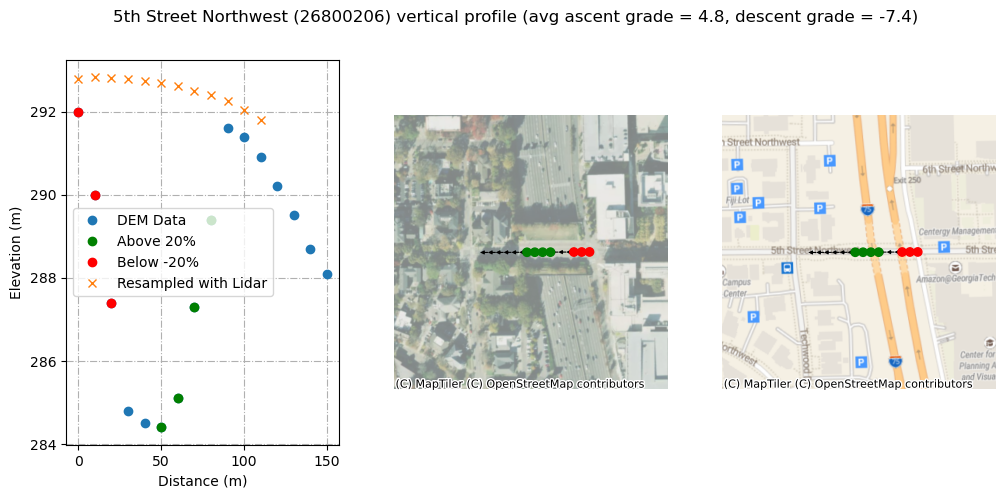

In [59]:
from importlib import reload
reload(elevation_tools)

#pick some examples to visaulize here
linkid = 26800206
grade_threshold = 20
elevation_tools.visualize(links,dem_crs,interpolated_points_dict,[linkid],grade_threshold,None,config['maptilerapikey'],one_off=True,lidar=True)

# Move on to Step 6 (Below code is test code)

In [ ]:
# # Calculating grade from sampled elevation
# #for storing the interpolated points with sampled elevation data
# import pickle
# with (network_filepath.parent/'elevation.pkl').open('rb') as fh:
#     interpolated_points_dict = pickle.load(fh)
# Calculate average up-grade and down-grade for each link using the interpolated points with sampled elevations
# # all_rise = {}
# # all_down = {}
# # max_rise = {}
# # min_rise = {}
# grade_threshold = 15

# for key, item in tqdm(interpolated_points_dict.items(),total=len(interpolated_points_dict)):     

#     #find the total distance to get average grade
#     total_distance = np.array(item['distances']).max()
    
#     #caluclate the elevation change between points and add to list
#     elevation_deltas = []
#     grades = []
#     bad_grades = []
#     for x in range(0,len(item['elevations'])-1):        
#         elev1 = item['elevations'][x]
#         elev2 = item['elevations'][x+1]
#         dist1 = item['distances'][x]
#         dist2 = item['distances'][x+1]
#         elevation_delta = (elev2-elev1)
#         elevation_deltas.append(elevation_delta)
#         distance_delta = (dist2-dist1)

#         segment_grade = elevation_delta / distance_delta * 100
#         grades.append(segment_grade)

#         #flag potentially bad elevation points
#         if np.abs(segment_grade) >= grade_threshold:
#             bad_grades.append(x)

#     #get total up and down
#     elevation_deltas = np.asarray(elevation_deltas)
#     up = elevation_deltas[elevation_deltas>0].sum()
#     down = np.absolute(elevation_deltas[elevation_deltas<0].sum()) #take absolute value at this point

#     #get average up and down grade
#     up_grade = up / total_distance * 100
#     down_grade = down / total_distance * 100
    
#     interpolated_points_dict[key].update(
#         {
#             'up': up,
#             'down': down, 
#             'up_grade': up_grade,
#             'down_grade': down_grade,
#             'elevation_deltas': elevation_deltas,
#             'grade_segments': grades,
#             'bad_grades': bad_grades
#         }
#     )



# # Tasks
# - We have a good way to plot/examine
# - We just need to clean the rest of the data
# - We have taken out underpasses, so now we should look at bridges and sample lidar stuff and then examine the results
# - Once that is done, smooth everything and caclulate the different variables
# # Plotting
# We want to better visualize the problem and identify the different types of situations:
# - Vertical profile with bad grades highlighed
#     - Different colors for up/down (arrows?)
#     - Ignore vertical exageration for now
# - Grade profile just showing the grades with bad ones highlighted (maybe even a dual axis graph)
# - Static map of where the link is + bad grades highlighted
# - Really, we want to export all the bad figures with a link to the osm way in the title


# # use west paces ferry to start with
# #linkid = 42901

# fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,3))

# # for linkid, item in tqdm(interpolated_points_dict.items()):

# #     if len(item['bad_grades']) == 0:
# #         continue

# #     if len(item['distances']) <= 2:
# #         continue

# cond = True
# while cond == True:
#     linkid = links['linkid'].sample(1).item()
#     item = interpolated_points_dict[linkid]
#     if (len(item['bad_grades']) > 0) & (len(item['distances']) > 2):
#         cond = False
    

# #https://github.com/geopandas/geopandas/issues/2279
# #https://stackoverflow.com/questions/8247973/how-do-i-specify-an-arrow-like-linestyle-in-matplotlib

# #Extract values
# x = np.array(item['distances'])
# y = np.array(item['elevations'])

# #gives you a boolean mask
# bad_up_grades = np.array(item['grade_segments']) >= grade_threshold
# bad_down_grades = np.array(item['grade_segments']) <= -grade_threshold

# #add an additional value
# bad_up_grades = np.hstack([np.array((False)),bad_up_grades])
# bad_down_grades = np.hstack([np.array((False)),bad_down_grades])

# bad_up_x = x[bad_up_grades]
# bad_up_y = y[bad_up_grades]

# bad_down_x = x[bad_down_grades]
# bad_down_y = y[bad_down_grades]

# #First Figure
# # Plot the original data and the smoothed curve
# ax1.plot(x, y, 'o', label='Original Data')
# #ax1.plot(x, new_y, 'x',label='Resampled with Lidar')
# ax1.grid(True,linestyle='-.')

# # plot bad points
# ax1.plot(bad_up_x,bad_up_y,'o',color='green',label=f'Above {grade_threshold}%')
# ax1.plot(bad_down_x,bad_down_y,'o',color='red',label=f'Below -{grade_threshold}%')

# #ax1.set_title(f'{road_name} (Linkid:{linkid}) Veritcal Cross-Section')
# ax1.set_xlabel('Distance (m)')
# ax1.set_ylabel('Elevation (m)')
# ax1.legend()

# #Second and Third figure

# #create geos to plot
# points = np.array([Point(x,y) for x,y in item['geometry']])
# line = LineString(item['geometry'])
# minx, miny, maxx, maxy = line.bounds
# # line_gdf = gpd.GeoDataFrame({'geometry':line},crs=dem_crs,index=[0])

# # use mask to just get bad one
# bad_up_grades_points = points[bad_up_grades]
# bad_up_grades_points = gpd.GeoDataFrame({'geometry':bad_up_grades_points},geometry='geometry',crs=dem_crs)
# bad_up_grades_points['type'] = '> 15%'

# bad_down_grades_points = points[bad_down_grades]
# bad_down_grades_points = gpd.GeoDataFrame({'geometry':bad_down_grades_points},geometry='geometry',crs=dem_crs)
# bad_down_grades_points['type'] = '< -15%'

# bad_grades_points = pd.concat([bad_up_grades_points,bad_down_grades_points])


# color_dict = {
#     '> 15%': 'green',
#     '< -15%': 'red',
# }
# bad_grades_points['color'] = bad_grades_points['type'].map(color_dict)

# bad_grades_points.plot(ax=ax2,color=bad_grades_points['color'],zorder=4)
# bad_grades_points.plot(ax=ax3,color=bad_grades_points['color'],zorder=4)

# #for drawing the link
# x = np.array([x for x, y in item['geometry']])
# y = np.array([y for x, y in item['geometry']])
# # length of line segment
# ds=10
# # number of line segments per interval
# Ns = np.round(np.sqrt( (x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2 ) / ds).astype(int)
# # sub-divide intervals w.r.t. Ns
# subdiv = lambda x, Ns=Ns: np.concatenate([ np.linspace(x[ii], x[ii+1], Ns[ii]) for ii, _ in enumerate(x[:-1]) ])
# x, y = subdiv(x), subdiv(y)
# ax2.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, width=.004, headlength=4, headwidth=4)
# ax3.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, width=.004, headlength=4, headwidth=4)

# #If you want a legend for map (didnot figure out arrow in the legend)
# # from matplotlib.lines import Line2D
# # from matplotlib.patches import Arrow
# # custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
# # #custom_line = Arrow(0,0,dx=0.1,dy=0,width=0.1,linewidth=0.5,color='black')
# # #custom_points.append()
# # leg_points = ax2.legend(custom_points, ['> 15%','< -15%'])#, title = 'Legend', alignment='right')
# # ax2.add_artist(leg_points)

# #make sure fig is square
# padding = 100
# x_diff = np.abs(maxx - minx)
# y_diff = np.abs(maxy - miny)
# diff = (x_diff - y_diff)/2
# if diff > 0:
#     ax2.set_xlim(minx-padding,maxx+padding)
#     ax2.set_ylim(miny-padding-diff,maxy+padding+diff)

#     ax3.set_xlim(minx-padding,maxx+padding)
#     ax3.set_ylim(miny-padding-diff,maxy+padding+diff)
# else:
#     ax2.set_xlim(minx-padding-np.abs(diff),maxx+padding+np.abs(diff))
#     ax2.set_ylim(miny-padding,maxy+padding)

#     ax3.set_xlim(minx-padding-np.abs(diff),maxx+padding+np.abs(diff))
#     ax3.set_ylim(miny-padding,maxy+padding)

# ax2.set_axis_off()
# ax3.set_axis_off()

# cx.add_basemap(ax2,zoom=17,source=cx.providers.MapTiler.Satellite(key=maptilerapikey),crs=bad_grades_points.crs,alpha=0.5)
# cx.add_basemap(ax3,zoom=16,source=cx.providers.MapTiler.Streets(key=maptilerapikey),crs=bad_grades_points.crs)

# #maybe if we wanted a high res version of this later
# #https://stackoverflow.com/questions/42483449/mapbox-gl-js-export-map-to-png-or-pdf

# name = links.loc[links['linkid']==linkid,'name'].item()
# plt.suptitle(f'{name} ({linkid}) vertical profile')
# plt.show()

# # try: 
# #     plt.savefig(Path(f'D:/bad_grades/{name}_{linkid}.png'),dpi=300)
# # except:
# #     'invalid filename'

# # #clear the axis
# # ax1.cla()
# # ax2.cla()
# # ax3.cla()

# from scipy.interpolate import splrep, splev

# #pick a random one to examine
# #linkid = int(abnormal_links.loc[new,'linkid'].sample(1).item())
# linkid = links.loc[still_bad,'linkid'].sample(1).item()
# #linkid = 53107

# #linkid = 28303#44061
# item = interpolated_points_dict[linkid]

# #title
# road_name = links.loc[links.index==linkid,'name'].item()

# #ax1 elements
# x = np.array(item['distances'])
# y = np.array(item['elevations'])
# new_y = np.array(lidar_sampled[linkid])

# #ax2 elements
# grade_x = np.array(range(0,len(x) - 1))
# grade_delta = np.diff(y) / 10 * 100
# lidar_delta = np.diff(new_y) / 10 * 100

# fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(9,3))

# # Plot the original data and the smoothed curve
# ax1.plot(x, y, 'o', label='Original Data')
# ax1.plot(x, new_y, 'x',label='Resampled with Lidar')
# ax1.grid(True,linestyle='-.')

# #find min
# y_min = np.min([y.min(),new_y.min()])
# y_max = np.max([y.max(),new_y.max()])

# ax1.set_xlim(0,np.ceil(x.max() / 10) * 10)
# ax1.set_ylim(np.floor(y_min/10)*10,np.ceil(y_max/10)*10)
# ax1.set_box_aspect(1)

# #ax1.set_title(f'{road_name} (Linkid:{linkid}) Veritcal Cross-Section')
# ax1.set_xlabel('Distance (m)')
# ax1.set_ylabel('Elevation (m)')
# ax1.legend()

# ax2.plot(grade_x, grade_delta, 'o', label='Original Grade')
# ax2.plot(grade_x, lidar_delta, 'x', label='lidar grade')


# ax2.set_xlabel('Distance (m)')
# ax2.set_ylabel('Grade %')
# ax2.set_box_aspect(1)
# ax2.legend()

# fig.suptitle(f'{road_name} (Linkid:{linkid})')
# plt.show()



# # Set ticks
# #plt.xlim(0,x.max())
# #plt.ylim()

# # Plot the dropped points as 'x's
# #plt.scatter(x_dropped, y_dropped, marker='x', color='red', label='Dropped Points')


# #turn item into a dataframe
# #df = pd.DataFrame.from_dict(item,orient='columns')

# # df['elev_change'] = df['elevations'].diff()
# # df['dist_change'] = df['distances'].diff()
# # df['change_rate'] = np.abs(df['elev_change'] / df['dist_change'])

#     total_down =  
#     all_rise[key] = total_rise
#     all_down[key] = total_down

#     if total_rise > 0:
#         max_rise[key] = elevation_deltas[elevation_deltas>0].max()
#     else:
#         max_rise[key] = 0

#     if total_down > 0:
#         min_rise[key] = np.absolute(elevation_deltas[elevation_deltas<0].min())
#     else:
#         min_rise[key] = 0

# #forward direction
# links['rise_m'] = pd.Series(all_rise).round(3)
# links['maxrise_m'] = pd.Series(max_rise).round(3)
# links['up_grade'] = (links['rise_m'] / links.geometry.length * 100).round(1)
# links.loc[links.length > interpolate_dist_m,'max_grade'] = (links['maxrise_m'] / interpolate_dist_m * 100).round(1)
# links.loc[links['max_grade'].isna(),'max_grade'] = (links['maxrise_m'] / links.length * 100).round(1)

# #reverse direction
# links['down_m'] = pd.Series(all_down).round(3)
# links['minrise_m'] = pd.Series(min_rise).round(3)
# links['down_grade'] = (links['down_m'] / links.geometry.length * 100).round(1)
# links.loc[links.length > interpolate_dist_m,'min_grade'] = (links['minrise_m'] / interpolate_dist_m * 100).round(1)
# links.loc[links['min_grade'].isna(),'min_grade'] = (links['minrise_m'] / links.length * 100).round(1)
# #reproject data and export
# #links.to_crs('epsg:2240',inplace=True)
# #links.to_crs(prev_crs).reset_index(drop=True).to_file(project_dir/'reconciled_network.gpkg',layer='links_w_signals_elevation')
# # Sample bridge elevations using LIDAR data
# Bridges and tunnels will have inaccurate grades becuase they don't follow the terrain. DEMs represent the lowest point possible so that they show the underlying natural terrain. Raw LIDAR data will have points representing builidngs, trees, and other things on the earth's surface.

# The download lidar script will download .LAZ files for the study area (LIDAR data is also available from the USGS site). These are then converted into TIF files using the lidar notebook. Once the TIF files have been made, the following code blocks sample new data that replaces previous elevation samples if the new sampled elevation is greater than the existing.

# A new column is created for the link geodataframe to examine where the newly sampled points increased/decreased the accuracy of the elevation data. The assumption is that more accurate data should reduce the number of extreme grade changes and by extension the average grade. It may not do that in all cases, so the next step will be to smooth the data.
# linkids = []
# for key, item in interpolated_points_dict.items():
#     if len(item['bad_grades']) > 0:
#         linkids.append(key)
# print(len(linkids),'exceed the threshold')
# exceeds_threshold = links.loc[linkids]
# #grab ones that are not bridges and don't exceed the threshold
# not_bridges = exceeds_threshold.loc[exceeds_threshold['bridge'].isna() ,['linkid','geometry']]
# print(len(not_bridges),'are not bridges')
# ### Find links that cross bridges, railroads, or creeks/rivers (likely an underpass)
# #grab bridges
# raw_osm = gpd.read_file(network_filepath/'filtered.gpkg',layer='osm_links')
# osm_attr = pd.read_pickle(network_filepath/'osm_attr.pkl')
# merged = raw_osm.merge(osm_attr,on='osm_linkid')
# bridges = merged.loc[~merged['bridge'].isna(),['osm_linkid','geometry']]
# bridges.to_crs(links.crs,inplace=True)
# #check if bridge crosses non-bridge
# crossing_links = []
# for idx, row in bridges.iterrows():
#     bridge = row['geometry']
#     crosses = not_bridges.loc[not_bridges.crosses(bridge),'linkid'].tolist()
#     if len(crosses) > 0:
#         crossing_links = crossing_links + crosses
# mask = list(set(crossing_links))
# not_bridges.loc[mask].reset_index(drop=True).explore()
# intersection = gpd.overlay(bridges,not_bridges,keep_geom_type=False)
# intersection.explore()
# ### Examine cross sections for these
# intersection['linkid'].nunique()
# len(mask)
# import contextily as cx

# # use west paces ferry to start with
# #linkid = 42901

# fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,3))

# # for linkid, item in tqdm(interpolated_points_dict.items()):

# #     if len(item['bad_grades']) == 0:
# #         continue

# #     if len(item['distances']) <= 2:
# #         continue

# linkid = not_bridges.loc[mask,'linkid'].sample(1).item()#intersection['linkid'].sample(1).item()
# item = interpolated_points_dict[linkid]

# #https://github.com/geopandas/geopandas/issues/2279
# #https://stackoverflow.com/questions/8247973/how-do-i-specify-an-arrow-like-linestyle-in-matplotlib

# #Extract values
# x = np.array(item['distances'])
# y = np.array(item['elevations'])

# #gives you a boolean mask
# bad_up_grades = np.array(item['grade_segments']) >= grade_threshold
# bad_down_grades = np.array(item['grade_segments']) <= -grade_threshold

# #add an additional value
# bad_up_grades = np.hstack([np.array((False)),bad_up_grades])
# bad_down_grades = np.hstack([np.array((False)),bad_down_grades])

# bad_up_x = x[bad_up_grades]
# bad_up_y = y[bad_up_grades]

# bad_down_x = x[bad_down_grades]
# bad_down_y = y[bad_down_grades]

# #First Figure
# # Plot the original data and the smoothed curve
# ax1.plot(x, y, 'o', label='Original Data')
# #ax1.plot(x, new_y, 'x',label='Resampled with Lidar')
# ax1.grid(True,linestyle='-.')

# # plot bad points
# ax1.plot(bad_up_x,bad_up_y,'o',color='green',label=f'Above {grade_threshold}%')
# ax1.plot(bad_down_x,bad_down_y,'o',color='red',label=f'Below -{grade_threshold}%')

# #ax1.set_title(f'{road_name} (Linkid:{linkid}) Veritcal Cross-Section')
# ax1.set_xlabel('Distance (m)')
# ax1.set_ylabel('Elevation (m)')
# ax1.legend()

# #Second and Third figure

# #create geos to plot
# points = np.array([Point(x,y) for x,y in item['geometry']])
# line = LineString(item['geometry'])
# minx, miny, maxx, maxy = line.bounds
# # line_gdf = gpd.GeoDataFrame({'geometry':line},crs=dem_crs,index=[0])

# # use mask to just get bad one
# bad_up_grades_points = points[bad_up_grades]
# bad_up_grades_points = gpd.GeoDataFrame({'geometry':bad_up_grades_points},geometry='geometry',crs=dem_crs)
# bad_up_grades_points['type'] = '> 15%'

# bad_down_grades_points = points[bad_down_grades]
# bad_down_grades_points = gpd.GeoDataFrame({'geometry':bad_down_grades_points},geometry='geometry',crs=dem_crs)
# bad_down_grades_points['type'] = '< -15%'

# bad_grades_points = pd.concat([bad_up_grades_points,bad_down_grades_points])


# color_dict = {
#     '> 15%': 'green',
#     '< -15%': 'red',
# }
# bad_grades_points['color'] = bad_grades_points['type'].map(color_dict)

# bad_grades_points.plot(ax=ax2,color=bad_grades_points['color'],zorder=4)
# bad_grades_points.plot(ax=ax3,color=bad_grades_points['color'],zorder=4)

# #for drawing the link
# x = np.array([x for x, y in item['geometry']])
# y = np.array([y for x, y in item['geometry']])
# # length of line segment
# ds=10
# # number of line segments per interval
# Ns = np.round(np.sqrt( (x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2 ) / ds).astype(int)
# # sub-divide intervals w.r.t. Ns
# subdiv = lambda x, Ns=Ns: np.concatenate([ np.linspace(x[ii], x[ii+1], Ns[ii]) for ii, _ in enumerate(x[:-1]) ])
# x, y = subdiv(x), subdiv(y)
# ax2.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, width=.004, headlength=4, headwidth=4)
# ax3.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, width=.004, headlength=4, headwidth=4)

# #If you want a legend for map (didnot figure out arrow in the legend)
# # from matplotlib.lines import Line2D
# # from matplotlib.patches import Arrow
# # custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
# # #custom_line = Arrow(0,0,dx=0.1,dy=0,width=0.1,linewidth=0.5,color='black')
# # #custom_points.append()
# # leg_points = ax2.legend(custom_points, ['> 15%','< -15%'])#, title = 'Legend', alignment='right')
# # ax2.add_artist(leg_points)

# #make sure fig is square
# padding = 100
# x_diff = np.abs(maxx - minx)
# y_diff = np.abs(maxy - miny)
# diff = (x_diff - y_diff)/2
# if diff > 0:
#     ax2.set_xlim(minx-padding,maxx+padding)
#     ax2.set_ylim(miny-padding-diff,maxy+padding+diff)

#     ax3.set_xlim(minx-padding,maxx+padding)
#     ax3.set_ylim(miny-padding-diff,maxy+padding+diff)
# else:
#     ax2.set_xlim(minx-padding-np.abs(diff),maxx+padding+np.abs(diff))
#     ax2.set_ylim(miny-padding,maxy+padding)

#     ax3.set_xlim(minx-padding-np.abs(diff),maxx+padding+np.abs(diff))
#     ax3.set_ylim(miny-padding,maxy+padding)

# ax2.set_axis_off()
# ax3.set_axis_off()

# cx.add_basemap(ax2,zoom=17,source=cx.providers.MapTiler.Satellite(key=maptilerapikey),crs=bad_grades_points.crs,alpha=0.5)
# cx.add_basemap(ax3,zoom=16,source=cx.providers.MapTiler.Streets(key=maptilerapikey),crs=bad_grades_points.crs)

# #maybe if we wanted a high res version of this later
# #https://stackoverflow.com/questions/42483449/mapbox-gl-js-export-map-to-png-or-pdf

# name = links.loc[links['linkid']==linkid,'name'].item()
# plt.suptitle(f'{name} ({linkid}) vertical profile')
# plt.show()

# # try: 
# #     plt.savefig(Path(f'D:/bad_grades/{name}_{linkid}.png'),dpi=300)
# # except:
# #     'invalid filename'

# # #clear the axis
# # ax1.cla()
# # ax2.cla()
# # ax3.cla()
# linkid = 28689
# item = interpolated_points_dict[linkid]

# distances = np.array(item['distances'])
# elevations = np.array(item['elevations'])
# bad_elevs = item['bad_grades']
# #temp_anom = [-0.17, -0.09, -0.11, -0.18, -0.3] # and so on...

# # further step could be to identify the high points and assign a lower weight 
# weights = np.ones_like(elevations)
# weights[elevations>311] = 0

# whittaker_smoother = WhittakerSmoother(
#     lmbda=150, order=2, data_length=len(elevations)#, weights=weights
# )

# smoothed = whittaker_smoother.smooth(elevations)

# plt.plot(distances,elevations)
# plt.plot(distances,smoothed)
# test1 = pd.Series(elevations).diff()
# test1_up = test1[test1>0].sum() / distances.max() * 100
# test2_down = test1[test1<0].sum() / distances.max() * 100
# print(test1_up,test2_down)
# test1 = pd.Series(smoothed).diff()
# test1_up = test1[test1>0].sum() / distances.max() * 100
# test2_down = test1[test1<0].sum() / distances.max() * 100
# print(test1_up,test2_down)
# # For these, Lidar probably isn't gonna help
# # so we just want to try the spline fit

# #identify large abnormalities and exclude stair cases (>25%)
# # thresholds = range(6,25+5)
# # counts = []
# # for threshold in thresholds:
# #     abnormal = ((links['max_grade'] > threshold) | (links['min_grade'] > threshold))#& (links['highway'] != 'steps')
# #     counts.append(links.loc[abnormal].shape[0])
# # np.array(counts)

# #before sensitvity, just use the haobing one (15% for local roads)
# threshold = 15
# abnormal = ((links['max_grade'] > threshold) | (links['min_grade'] > threshold))#& (links['highway'] != 'steps')
# abnormal_links = links[abnormal]
# print(f"{abnormal.sum()}/{links.shape[0]} links have at least one point exceeding {threshold}% ({abnormal_links.length.sum().round(0)}/{links.length.sum().round(0)} km)")
# abnormal_links['length_km'] = abnormal_links.length
# print(abnormal_links.groupby('highway')['length_km'].sum().round(0).sort_values(ascending=False))

# print(abnormal_links['highway'].value_counts().sort_values(ascending=False))
# # Method 1
# bridge_tif_fps = list((Path('D:/') / 'bridge_tif').glob('*.tif'))
# abnormal_links.to_crs(rasterio.open(bridge_tif_fps[0]).crs,inplace=True)
# lidar_sampled = dict()

# for bridge_tif_fp in tqdm(bridge_tif_fps):
#     #open the raster using the link
#     bridge_tif = rasterio.open(bridge_tif_fp)

#     #find all links that intersect with the current raster
#     xmin, ymin, xmax, ymax = bridge_tif.bounds
#     bbox = box(xmin,ymin,xmax,ymax)
#     intersection = abnormal_links.intersects(bbox)
    
#     if (intersection == True).any():
#         for index in abnormal_links[intersection].index:
#             dict_values = interpolated_points_dict.get(index)

#             #change the crs
#             #open the first one to just get the crs
#             geometry = [Point(x,y) for x,y in dict_values['geometry']]
#             gdf = gpd.GeoDataFrame({'geometry':geometry},crs=dem_crs)
#             gdf.to_crs(bridge_tif.crs,inplace=True)
#             geometry = list(zip(gdf.geometry.x,gdf.geometry.y))

#             sampled = np.array([val[0] for val in bridge_tif.sample(geometry)])

#             #check for nan values in sampled
#             #match the nan points to the nearest cell
            

#             #if at least one non-null value
#             #replace elevation if value is higher?
#             if np.isnan(sampled).all() == False:
#                 lidar_sampled[index] =  np.nanmax([sampled,dict_values['elevations']],axis = 0)

# # Method 2
# Uses the raw lidar points instead.
# #grab bridges

# import pickle
# with Path('D:/lidar_points.pkl').open('rb') as fh:
#     lidar_points = pickle.load(fh)

# lidar_points.to_crs(prev_crs,inplace=True)
# spatial_index = lidar_points.sindex


# lidar_sampled = dict()
# incomplete = []

# for index in tqdm(abnormal_links.index):
#     dict_values = interpolated_points_dict.get(index)

#     geometry = [Point(x,y) for x,y in dict_values['geometry']]
#     gdf = gpd.GeoDataFrame({'geometry':geometry},crs=dem_crs)
#     gdf.to_crs(prev_crs,inplace=True)

#     #buffer the data
#     buffer_m = 20
#     gdf.geometry = gdf.buffer(buffer_m)

#     #get the gdf bounding box
#     polygon = gdf.geometry.unary_union.convex_hull
    
#     #use spatial index to only select a small number of points
#     possible_matches_index = list(spatial_index.intersection(polygon.bounds))
#     possible_matches = lidar_points.iloc[possible_matches_index]
    
#     #add an index column for the overlay part
#     gdf.reset_index(inplace=True)
#     precise_matches = gpd.overlay(possible_matches,gdf,how='intersection')

#     if len(precise_matches) == 0:
#         continue

#     if gdf['index'].isin(set(precise_matches['index'].tolist())).all() == False:
#         #this is where we might want to increase the buffer on the remaining points
        
#         #assign nan
#         incomplete.append(index)

#     new_values = precise_matches.groupby('index')['elevation_m'].mean()
#     gdf['new_elevation_m'] = gdf['index'].map(new_values)
#     new_values = np.array(gdf['new_elevation_m'])

#     lidar_sampled[index] = np.nanmax([new_values,dict_values['elevations']],axis = 0)
# lidar_sampled[36]
# #interpolated_points_dict[36]
# all_rise = {}
# all_down = {}
# max_rise = {}
# min_rise = {}

# for key, item in tqdm(lidar_sampled.items(),total=len(lidar_sampled)):     

#     elevation_deltas = []
    
#     #then caluclate the elevation change with the smoothed data
#     for x in range(0,len(item)-1):        
#         elev1 = item[x]
#         elev2 = item[x+1]
#         elevation_delta = (elev2-elev1)
#         elevation_deltas.append(elevation_delta)

#     elevation_deltas = np.asarray(elevation_deltas)
#     total_rise = elevation_deltas[elevation_deltas>0].sum()
#     total_down = np.absolute(elevation_deltas[elevation_deltas<0].sum()) #take absolute value at this point
#     all_rise[key] = total_rise
#     all_down[key] = total_down

#     if total_rise > 0:
#         max_rise[key] = elevation_deltas[elevation_deltas>0].max()
#     else:
#         max_rise[key] = 0

#     if total_down > 0:
#         min_rise[key] = np.absolute(elevation_deltas[elevation_deltas<0].min())
#     else:
#         min_rise[key] = 0

# #forward direction
# links['new_rise_m'] = pd.Series(all_rise).round(3)
# links['new_maxrise_m'] = pd.Series(max_rise).round(3)
# links['new_up_grade'] = (links['new_rise_m'] / links.geometry.length * 100).round(1)
# links.loc[links.length > interpolate_dist_m,'new_max_grade'] = (links['new_maxrise_m'] / interpolate_dist_m * 100).round(1)
# links.loc[links['new_max_grade'].isna(),'new_max_grade'] = (links['new_maxrise_m'] / links.length * 100).round(1)

# #reverse direction
# links['new_down_m'] = pd.Series(all_down).round(3)
# links['new_minrise_m'] = pd.Series(min_rise).round(3)
# links['new_down_grade'] = (links['new_down_m'] / links.geometry.length * 100).round(1)
# links.loc[links.length > interpolate_dist_m,'new_min_grade'] = (links['new_minrise_m'] / interpolate_dist_m * 100).round(1)
# links.loc[links['new_min_grade'].isna(),'new_min_grade'] = (links['new_minrise_m'] / links.length * 100).round(1)

# # See where elevation data improved
# all_rise = {}
# all_down = {}
# max_rise = {}
# min_rise = {}

# for key, item in tqdm(lidar_sampled.items(),total=len(lidar_sampled)):     

#     elevation_deltas = []
    
#     #then caluclate the elevation change with the smoothed data
#     for x in range(0,len(item)-1):        
#         elev1 = item[x]
#         elev2 = item[x+1]
#         elevation_delta = (elev2-elev1)
#         elevation_deltas.append(elevation_delta)

#     elevation_deltas = np.asarray(elevation_deltas)
#     total_rise = elevation_deltas[elevation_deltas>0].sum()
#     total_down = np.absolute(elevation_deltas[elevation_deltas<0].sum()) #take absolute value at this point
#     all_rise[key] = total_rise
#     all_down[key] = total_down

#     if total_rise > 0:
#         max_rise[key] = elevation_deltas[elevation_deltas>0].max()
#     else:
#         max_rise[key] = 0

#     if total_down > 0:
#         min_rise[key] = np.absolute(elevation_deltas[elevation_deltas<0].min())
#     else:
#         min_rise[key] = 0

# #forward direction
# links['new_rise_m'] = pd.Series(all_rise).round(3)
# links['new_maxrise_m'] = pd.Series(max_rise).round(3)
# links['new_up_grade'] = (links['new_rise_m'] / links.geometry.length * 100).round(1)
# links.loc[links.length > interpolate_dist_m,'new_max_grade'] = (links['new_maxrise_m'] / interpolate_dist_m * 100).round(1)
# links.loc[links['new_max_grade'].isna(),'new_max_grade'] = (links['new_maxrise_m'] / links.length * 100).round(1)

# #reverse direction
# links['new_down_m'] = pd.Series(all_down).round(3)
# links['new_minrise_m'] = pd.Series(min_rise).round(3)
# links['new_down_grade'] = (links['new_down_m'] / links.geometry.length * 100).round(1)
# links.loc[links.length > interpolate_dist_m,'new_min_grade'] = (links['new_minrise_m'] / interpolate_dist_m * 100).round(1)

# prev = abnormal_links.shape[0]
# fixed = ((links['new_max_grade'] <= threshold) & (links['new_min_grade'] <= threshold))
# still_bad = ((links['new_max_grade'] > threshold) & (links['new_min_grade'] > threshold))
# print(f'{fixed.sum()} / {prev} abnormal links fixed')
# print(f'{still_bad.sum()} are still abnormal')
# print(f'{prev-fixed.sum()-still_bad.sum()} did not overlap with a bridge tif')

# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.interpolate import splrep, splev

# #pick a random one to examine
# #linkid = int(abnormal_links.loc[new,'linkid'].sample(1).item())
# linkid = links.loc[still_bad,'linkid'].sample(1).item()
# #linkid = 53107

# #linkid = 28303#44061
# item = interpolated_points_dict[linkid]

# #title
# road_name = links.loc[links.index==linkid,'name'].item()

# #ax1 elements
# x = np.array(item['distances'])
# y = np.array(item['elevations'])
# new_y = np.array(lidar_sampled[linkid])

# #ax2 elements
# grade_x = np.array(range(0,len(x) - 1))
# grade_delta = np.diff(y) / 10 * 100
# lidar_delta = np.diff(new_y) / 10 * 100

# fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(9,3))

# # Plot the original data and the smoothed curve
# ax1.plot(x, y, 'o', label='Original Data')
# ax1.plot(x, new_y, 'x',label='Resampled with Lidar')
# ax1.grid(True,linestyle='-.')

# #find min
# y_min = np.min([y.min(),new_y.min()])
# y_max = np.max([y.max(),new_y.max()])

# ax1.set_xlim(0,np.ceil(x.max() / 10) * 10)
# ax1.set_ylim(np.floor(y_min/10)*10,np.ceil(y_max/10)*10)
# ax1.set_box_aspect(1)

# #ax1.set_title(f'{road_name} (Linkid:{linkid}) Veritcal Cross-Section')
# ax1.set_xlabel('Distance (m)')
# ax1.set_ylabel('Elevation (m)')
# ax1.legend()

# ax2.plot(grade_x, grade_delta, 'o', label='Original Grade')
# ax2.plot(grade_x, lidar_delta, 'x', label='lidar grade')


# ax2.set_xlabel('Distance (m)')
# ax2.set_ylabel('Grade %')
# ax2.set_box_aspect(1)
# ax2.legend()

# fig.suptitle(f'{road_name} (Linkid:{linkid})')
# plt.show()



# # Set ticks
# #plt.xlim(0,x.max())
# #plt.ylim()

# # Plot the dropped points as 'x's
# #plt.scatter(x_dropped, y_dropped, marker='x', color='red', label='Dropped Points')


# #turn item into a dataframe
# #df = pd.DataFrame.from_dict(item,orient='columns')

# # df['elev_change'] = df['elevations'].diff()
# # df['dist_change'] = df['distances'].diff()
# # df['change_rate'] = np.abs(df['elev_change'] / df['dist_change'])
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.interpolate import splrep, splev

# #pick a random one to examine
# #linkid = int(abnormal_links.loc[new,'linkid'].sample(1).item())
# linkid = links.loc[still_bad,'linkid'].sample(1).item()
# #linkid = 53107

# #linkid = 28303#44061
# item = interpolated_points_dict[linkid]

# links.loc[links.index==linkid,['up_grade','max_grade','min_grade','new_up_grade','down_grade','new_down_grade']].squeeze()
# links.loc[links.index==linkid,['up_grade','max_grade','min_grade','new_up_grade','down_grade','new_down_grade']].squeeze()
# links.loc[links.index==linkid,['up_grade','max_grade','min_grade','new_up_grade','down_grade','new_down_grade']].squeeze()
# #title
# road_name = links.loc[links.index==linkid,'name'].item()

# #ax1 elements
# x = np.array(item['distances'])
# y = np.array(item['elevations'])
# new_y = np.array(lidar_sampled[linkid])

# #ax2 elements
# grade_x = np.array(range(0,len(x) - 1))
# grade_delta = np.diff(y) / 10 * 100
# lidar_delta = np.diff(new_y) / 10 * 100

# fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(9,3))

# # Plot the original data and the smoothed curve
# ax1.plot(x, y, 'o', label='Original Data')
# ax1.plot(x, new_y, 'x',label='Resampled with Lidar')
# ax1.grid(True,linestyle='-.')

# #find min
# y_min = np.min([y.min(),new_y.min()])
# y_max = np.max([y.max(),new_y.max()])

# ax1.set_xlim(0,np.ceil(x.max() / 10) * 10)
# ax1.set_ylim(np.floor(y_min/10)*10,np.ceil(y_max/10)*10)
# ax1.set_box_aspect(1)

# #ax1.set_title(f'{road_name} (Linkid:{linkid}) Veritcal Cross-Section')
# ax1.set_xlabel('Distance (m)')
# ax1.set_ylabel('Elevation (m)')
# ax1.legend()

# ax2.plot(grade_x, grade_delta, 'o', label='Original Grade')
# ax2.plot(grade_x, lidar_delta, 'x', label='lidar grade')


# ax2.set_xlabel('Distance (m)')
# ax2.set_ylabel('Grade %')
# ax2.set_box_aspect(1)
# ax2.legend()

# fig.suptitle(f'{road_name} (Linkid:{linkid})')
# plt.show()



# # Set ticks
# #plt.xlim(0,x.max())
# #plt.ylim()

# # Plot the dropped points as 'x's
# #plt.scatter(x_dropped, y_dropped, marker='x', color='red', label='Dropped Points')


# #turn item into a dataframe
# #df = pd.DataFrame.from_dict(item,orient='columns')

# # df['elev_change'] = df['elevations'].diff()
# # df['dist_change'] = df['distances'].diff()
# # df['change_rate'] = np.abs(df['elev_change'] / df['dist_change'])prev = abnormal_links.shape[0]
# fixed = ((links['new_max_grade'] <= threshold) & (links['new_min_grade'] <= threshold))
# still_bad = ((links['new_max_grade'] > threshold) & (links['new_min_grade'] > threshold))
# print(f'{fixed.sum()} / {prev} abnormal links fixed')
# print(f'{still_bad.sum()} are still abnormal')
# print(f'{prev-fixed.sum()-still_bad.sum()} did not overlap with a bridge tif')
# prev = abnormal_links.shape[0]
# fixed = ((links['new_max_grade'] <= threshold) & (links['new_min_grade'] <= threshold))
# still_bad = ((links['new_max_grade'] > threshold) & (links['new_min_grade'] > threshold))
# print(f'{fixed.sum()} / {prev} abnormal links fixed')
# print(f'{still_bad.sum()} are still abnormal')
# print(f'{prev-fixed.sum()-still_bad.sum()} did not overlap with a bridge tif')links.loc[links['new_min_grade'].isna(),'new_min_grade'] = (links['new_minrise_m'] / links.length * 100).round(1)

# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.interpolate import splrep, splev

# linkid = 28303#44061
# item = interpolated_points_dict[linkid]

# x = item['distances']
# y = item['elevations']
# new_y = new[linkid]

# # Plot the original data and the smoothed curve
# plt.plot(x, y, 'o', label='Original Data')
# plt.plot(x, new_y, 'o',label='Resampled with Lidar')

# # Plot the dropped points as 'x's
# #plt.scatter(x_dropped, y_dropped, marker='x', color='red', label='Dropped Points')

# #plt.title('10th Street Northwest (westward direction, tech to midtown) Veritcal Cross-Section')
# plt.xlabel('Distance (m)')
# plt.ylabel('Elevation (m)')
# plt.legend()
# plt.show()
# #turn item into a dataframe
# #df = pd.DataFrame.from_dict(item,orient='columns')

# # df['elev_change'] = df['elevations'].diff()
# # df['dist_change'] = df['distances'].diff()
# # df['change_rate'] = np.abs(df['elev_change'] / df['dist_change'])
# ### Based on Haobing's paper
# Spline fitting function
# x as linear distance and y as elevation

# current issue is that segments are not long enough as is, bridges need to extend forwards/backwards to have more data on the surrounding terrain. In the paper there are 3 km long segments. We can either try to linemerge lines to make them longer or add extensions

# this is where the weighting prolly comes in

# [Scipy Splrep](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep)


# # Assuming x, y, x_dropped, y_dropped, and spl are defined as in your code
# x = np.array(df_copy['distances'])
# y = np.array(df_copy['elevations'])

# df_dropped = df.loc[~df.index.isin(df_copy.index)]

# x_dropped = np.array(df_dropped['distances'])
# y_dropped = np.array(df_dropped['elevations'])

# #spline technique (we're not doing OLS i think because we don't have ground truth data?)
# lambda_parameter = 3000 # 500 for local road and 3000 for highways
# alpha = 99999990000 #paper used between 1000 and 10000
# # i believe higher is smoother
# spl = splrep(x,y,s=alpha)
# y2 = splev(x,spl)

# # Plot the original data and the smoothed curve
# plt.plot(x, y, 'o', label='Original Data')
# plt.plot(x, y2, label='Smoothed Curve')

# # Plot the dropped points as 'x's
# plt.scatter(x_dropped, y_dropped, marker='x', color='red', label='Dropped Points')

# plt.title('10th Street Northwest (westward direction, tech to midtown) Veritcal Cross-Section')
# plt.xlabel('Distance (m)')
# plt.ylabel('Elevation (m)')
# plt.legend()
# plt.show()

# links_copy = links.copy()


# # Assuming x, y, x_dropped, y_dropped, and spl are defined as in your code
# x = np.array(df_copy['distances'])
# y = np.array(df_copy['elevations'])

# df_dropped = df.loc[~df.index.isin(df_copy.index)]

# x_dropped = np.array(df_dropped['distances'])
# y_dropped = np.array(df_dropped['elevations'])

# #spline technique (we're not doing OLS i think because we don't have ground truth data?)
# lambda_parameter = 3000 # 500 for local road and 3000 for highways
# alpha = 99999990000 #paper used between 1000 and 10000
# # i believe higher is smoother
# spl = splrep(x,y,s=alpha)
# y2 = splev(x,spl)

# # Plot the original data and the smoothed curve
# plt.plot(x, y, 'o', label='Original Data')
# plt.plot(x, y2, label='Smoothed Curve')

# # Plot the dropped points as 'x's
# plt.scatter(x_dropped, y_dropped, marker='x', color='red', label='Dropped Points')

# plt.title('10th Street Northwest (westward direction, tech to midtown) Veritcal Cross-Section')
# plt.xlabel('Distance (m)')
# plt.ylabel('Elevation (m)')
# plt.legend()

# links_copy['tunnel'].value_counts()

# vals = ['yes','buidling_passage']
# links_copy['tunnel'] = links_copy['tunnel'].isin(vals)
# plt.show()

# grade_cols = links_copy.columns.tolist()[-8:]
# bridge_or_tunnel = (links_copy['tunnel']==True) | (links_copy['bridge']==True)
# links_copy.loc[bridge_or_tunnel,['name','geometry']+grade_cols].explore()
# links_copy.loc[bridge_or_tunnel,grade_cols] = 0
# ## Side profile to show example (10th Street over the connector)
# links.columns
# linkid = 28303

# street_name = links.at[linkid,'name']
# distances = interpolated_points_dict[linkid]['distances']
# elevations = interpolated_points_dict[linkid]['elevations']
# geometries = interpolated_points_dict[linkid]['geometry']

# plt.scatter(distances,elevations)
# plt.title(street_name)
# plt.xlabel('Distance (m)')
# plt.ylabel('Elevation (m)')
# import folium
# import geopandas as gpd
# from shapely.geometry import LineString
# import matplotlib.pyplot as plt
# import base64
# from io import BytesIO

# # Replace 'linkid' with your unique identifier for the road segment
# linkid = 28303

# # Extracting relevant data
# street_name = links.at[linkid,'name']
# distances = interpolated_points_dict[linkid]['distances']
# elevations = interpolated_points_dict[linkid]['elevations']
# geometries = interpolated_points_dict[linkid]['geometry']

# # Creating a GeoDataFrame for the road segment
# road_geometry = LineString(geometries)
# road_gdf = gpd.GeoDataFrame(geometry=[road_geometry],crs=src.crs)
# road_gdf.to_crs('epsg:4326',inplace=True)

# # Create a Folium map centered on the road segment
# map_center = [road_gdf.centroid.y, road_gdf.centroid.x]
# mymap = folium.Map(location=map_center, zoom_start=15)

# # Save the scatter plot as an image
# scatter_plot_filename = 'scatter_plot.png'
# plt.scatter(distances, elevations, color='red', marker='o', label='Cross-section')
# plt.title(street_name)
# plt.xlabel('Distance (m)')
# plt.ylabel('Elevation (m)')
# plt.legend()
# plt.savefig(scatter_plot_filename)
# plt.close()

# # Encode the image to base64
# with open(scatter_plot_filename, 'rb') as img_file:
#     encoded_image = base64.b64encode(img_file.read()).decode('utf-8')

# # Add the scatter plot image to the map popup
# popup_content = """
#     <h4>{}</h4>
#     <img src="data:image/png;base64,{}" alt="Scatter Plot" width="400px">
# """.format(street_name, encoded_image)

# popup = folium.Popup(html=popup_content, max_width=500)
# folium.GeoJson(road_gdf,popup=popup,lazy=True).add_to(mymap)

# # Save the Folium map as an HTML file
# #map_filename = 'road_map_with_scatter_plot.html'
# #mymap.save(map_filename)

# # Display the Folium map
# mymap

# ## Set to zero for now (we'll update these once the rest of the paper is intergrated)
# links.columns
# links.columns
# # #example point grade calculation for finding rapid changes
# # linkid = 40

# # point1 = Point(interpolated_points_dict[linkid]['geometry'][0])
# # point2 = Point(interpolated_points_dict[linkid]['geometry'][1])
# # point1.distance(point2)

# # elev1 = interpolated_points_dict[linkid]['elevations'][0]
# # elev2 = interpolated_points_dict[linkid]['elevations'][1]

# # grade = (elev2-elev1)/(point1.distance(point2))
# # grade

# # calculates point grade (deprecated)
# # item = interpolated_points_dict[linkid]
# # grades = []

# # for x in range(0,len(item['elevations'])-1):
# #     point1 = Point(item['geometry'][x])
# #     point2 = Point(item['geometry'][x+1])

# #     elev1 = item['elevations'][x]
# #     elev2 = item['elevations'][x+1]

# #     grade = (elev2-elev1)/(point1.distance(point2))
# #     grades.append(grade)

# # grades = np.asarray(grades)
# # grades[grades>0].mean()

# # # calculate average point grade
# # # 3 mins

# # grades_dict = {}

# # for key, item in tqdm(interpolated_points_dict.items(),total=len(interpolated_points_dict)): 
# #     grades = []


# #     for x in range(0,len(item['elevations'])-1):
# #         point1 = Point(item['geometry'][x])
# #         point2 = Point(item['geometry'][x+1])

# #         elev1 = item['elevations'][x]
# #         elev2 = item['elevations'][x+1]

# #         grade = (elev2-elev1)/(point1.distance(point2))
# #         grades.append(grade)

# #     grades = np.asarray(grades)
# #     grades_dict[key] = grades[grades>0].mean()
    